# "Gaussian Processes 2 - Application"
> "We look at how to use GP to learn non-linefar partial differential equations"

- toc:true
- branch: master
- badges: true
- comments: true
- author: John J. Molina
- categories: [Gaussian Processes]

We reproduce a recent paper by Raissi and Karniadakis {% cite Raissi2018 %}, in which Gaussian Processes are used to learn partial differential equations from "small" data.
In particular, it is assumed the the general form of the underlying PDE is known, while the model parameters are unspecified.
The proposed method is then used to infer the parameters of the one-dimensional Burgers', Korteweg-de Vries, Kuramoto-Sivishinky, and non-linear Schrödinger equations.
The datasets are taken from earlier work of Rudy et al. {% cite Rudy2017 %}, who have proposed a sparse-regression technique to discover the symbolic form of the governing pde.
The full dataset is available on the [PDE-FIND](https://github.com/snagcliffs/PDE-FIND/tree/master/Datasets) github page (in scipy.io format).

- [Hidden physics models: Machine learning of nonlinear partial differential equations](https://doi.org/10.1016/j.jcp.2017.11.039)<br>
M. Raissi and G. E. Karniadakis, Journal of Computational Physics 357, 125 (2018)

- [Data-driven discovery of partial differential equations](http://advances.sciencemag.org/lookup/doi/10.1126/sciadv.1602614)<br>
S. H. Rudy, S. L. Brunton, J. L. Proctor, and J. N. Kutz, Science Advances 3, e1602614 (2017)

# Preliminaries

In [1]:
#collapse
import jax.numpy as np
import pandas    as pd
import numpy     as onp
import matplotlib    as mpl
import matplotlib.pyplot      as plt
import matplotlib.patheffects as PathEffects
import scipy.io as sio

from scipy import optimize
from jax   import grad, jit, vmap, jacfwd, jacrev
from jax.numpy.lax_numpy import _wraps
from jax.config    import config; config.update("jax_enable_x64", True)
from functools     import partial,reduce
from mpmath        import mp
from numpy         import random
mpl.style.use(['seaborn-poster', 'seaborn-muted'])

#betanalphas' colormap
colors = ["#DCBCBC","#C79999","#B97C7C","#A25050","#8F2727", "#7C0000","#DCBCBC20", "#8F272720","#00000060"]
color  = {i[0]:i[1] for i in zip(['light','light_highlight','mid','mid_highlight','dark','dark_highlight','light_trans','dark_trans','superfine'],colors)}

def addtxt(ax, x, y, txt, fs=8, lw=3, clr='k', bclr='w', rot=0):
    """Add text to figure axis"""
    return ax.text(x, y, txt, color=clr, ha='left', transform=ax.transAxes, rotation=rot, weight='bold',
                   path_effects=[PathEffects.withStroke(linewidth=lw, foreground=bclr)], fontsize=fs)

The following function will load the solutions obtained by Rudy et al., as well as extract the training data (and save it to a separate file for easy recovery).

In [28]:
#collapse-show
#def sio2hdf5(*, name):
def process_data(*, name):
    """Function to load Rudy et al's data set (save format was not the same for all files...)
    Also creates text files containing the training data, as specified in Raissi's paper

    Args: 
      name : Name of equation. Should be one of (kdv, burgers, nls, harmonic_osc, kuramoto_sivishinky)

    Returns:
        t,x,u,p : time array, position array, solution array, training data parameters (time stamp, number of traning points)
    """
    names = ['burgers', 'kdv', 'kuramoto_sivishinky', 'nls', 'harmonic_osc']
    if name not in names:
        print('Unknown name')
        return  
    data     = sio.loadmat(f'../_simulation_data/PDE-FIND/Datasets/{name}.mat')

    if name in ['kdv', 'burgers']:
        u = np.real(data['usol']).transpose()
        x = data['x'][0]
        t = data['t'][:,0]
    if name in ['kuramoto_sivishinky']:
        u = data['uu'].transpose()
        x = data['x'][:,0]
        t = data['tt'][0]
    if name in ['nls', 'harmonic_osc']:
        u = data['usol']
        x = data['x'][0]
        t = data['t'][:,0]
    
    random.seed(12345)
    save_loc = f'../_simulation_data/{name}'
    fmt      = "%20.16g"
    params   = {}
    for tag,ts,num in zip(names, [81, 162, 203, 407], [[71,69], [111,109], [301, 299], [49, 51]]): # Raissi's parameters
        params[tag] = {'ts' : [ts, ts+1], 'num' : num} 
    p        = params[name]
    i0,i1    = p['ts']
    df       = pd.DataFrame({'x':x, 'u0':u[i0], 'u1':u[i1]})
    df.to_csv(f'{save_loc}_all.dat', sep="\t", float_format=fmt, index=False)     # full data for both time steps
    for i,n,l in zip(p['ts'], p['num'], ['0', '1']):
        training = list(np.sort(random.choice(len(x), size = n, replace=False)))
        p[f'training_{l}'] = training
        df = pd.DataFrame({'id':training, 'x':x[training], 'u':u[i,training]})
        df.to_csv(f'{save_loc}_{l}.dat', sep="\t", float_format=fmt, index=False) # random selection of training points
            
    return np.array(t), np.array(x), np.array(u), p

Below, we plot the spatio-temporal solutions $u(t)$ for each of the four equations (compare with the plots found in Raissi and Karniadakis' paper).

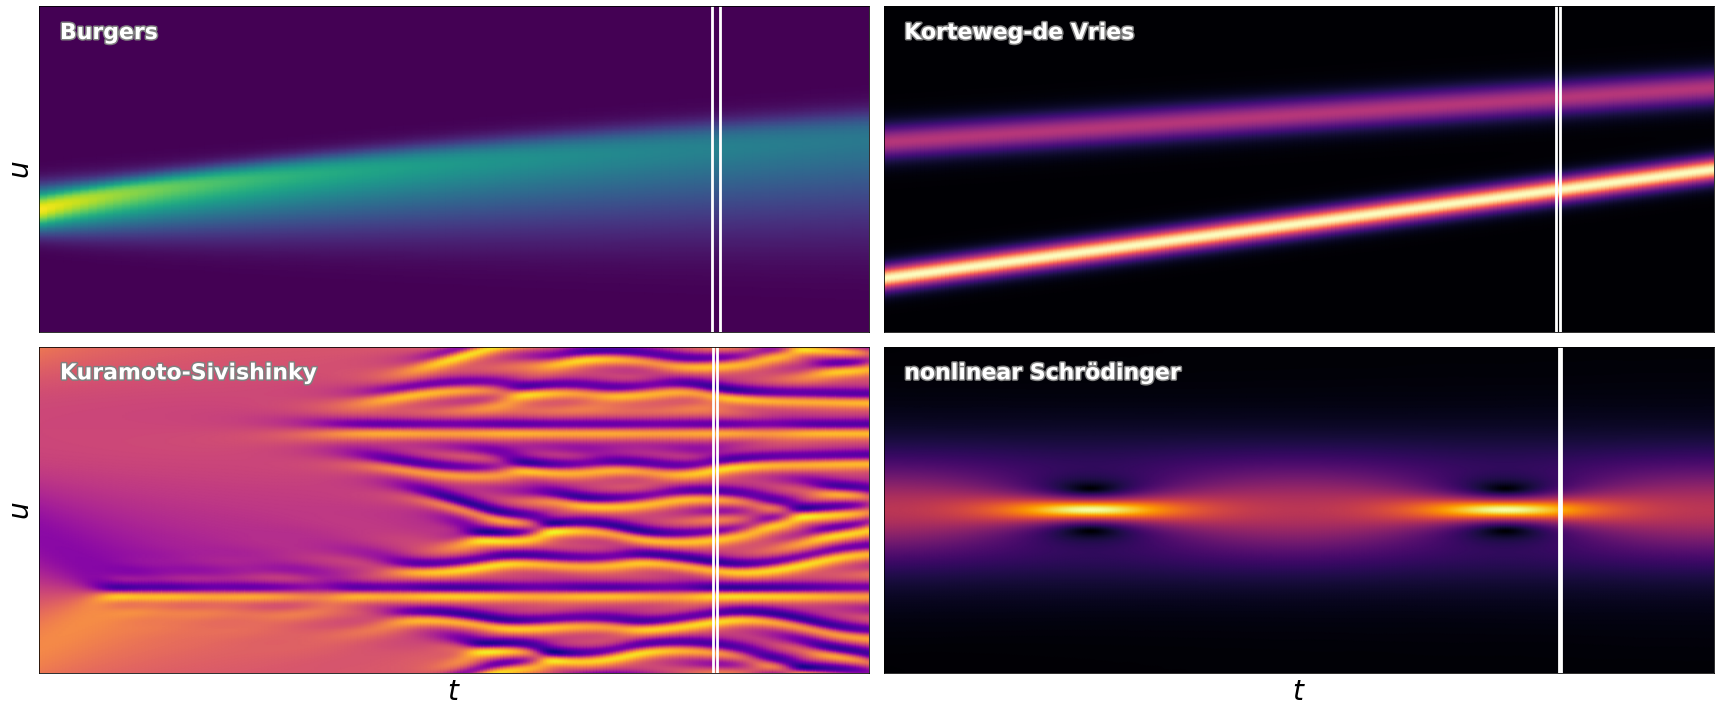

In [31]:
#hide_input
def plot_solutions():
    fig, grid      = plt.subplots(figsize=(24,10), ncols=2, nrows=2)
    axes           = grid.flatten()
    identity,norm  = lambda x : x, lambda x : np.absolute(x)
    funcs          = [identity, identity, identity, norm, norm]
    cmaps          = [mpl.cm.viridis,mpl.cm.magma,  mpl.cm.plasma, mpl.cm.inferno, mpl.cm.cividis]
    labels         = [r'Burgers', r'Korteweg-de Vries', r'Kuramoto-Sivishinky', r'nonlinear Schrödinger']
    names          = ['burgers', 'kdv', 'kuramoto_sivishinky', 'nls']


    for name,func,cm,l,ax in zip(names, funcs, cmaps, labels, axes):
        t,x,u,p    = process_data(name = name)
        T,X        = np.meshgrid(t,x,indexing='ij')
        ax.pcolormesh(T,X,func(u), shading='gouraud', cmap=cm)
        ax.vlines(t[p['ts']], np.min(x), np.max(x), colors='w')
        addtxt(ax, 0.025, 0.9, l, fs=22, clr='w', bclr='gray')
    

    for ax in axes:
        ax.set_xticks([]), ax.set_yticks([])
    grid[0,0].set_ylabel(r'$u$', fontsize=28)
    grid[1,0].set_ylabel(r'$u$', fontsize=28); grid[1,0].set_xlabel(r'$t$', fontsize=28)
    grid[1,1].set_xlabel(r'$t$', fontsize=28)
    fig.tight_layout()
    plt.show()
plot_solutions()

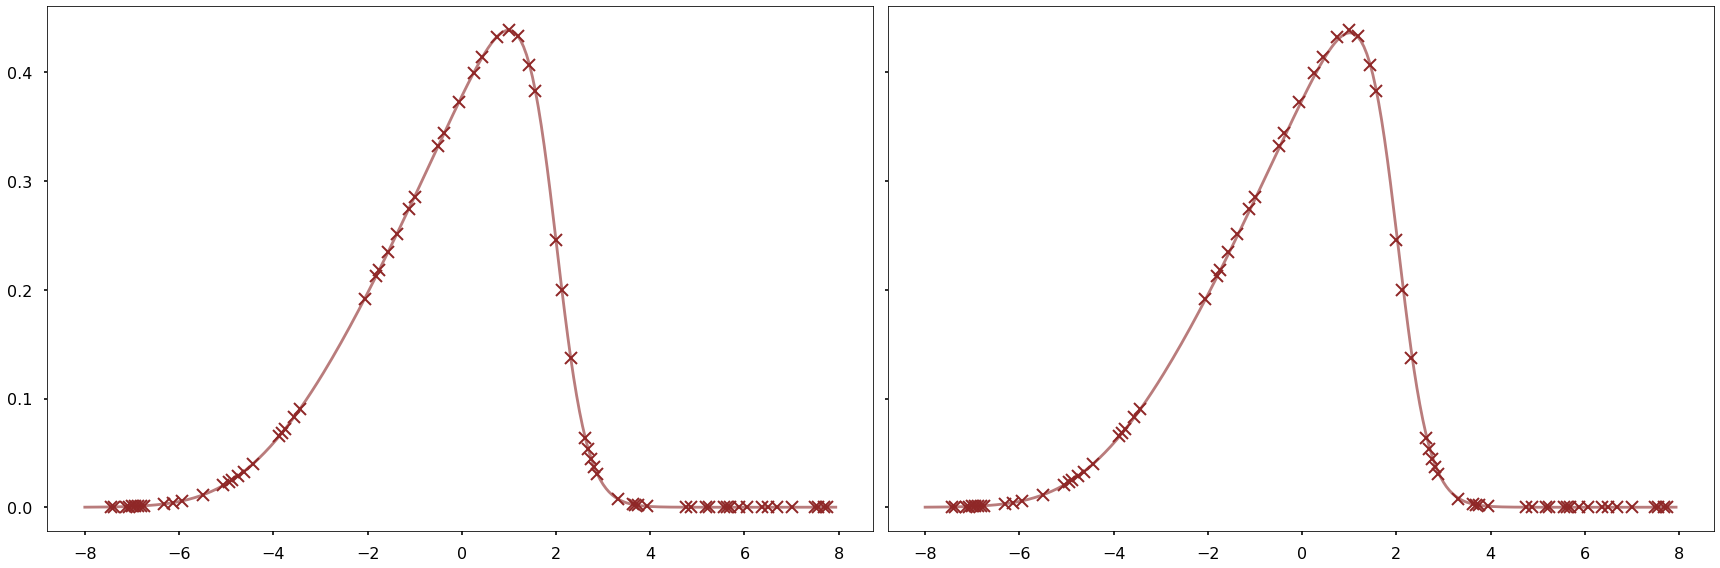

In [73]:
def plot_solution(name):
    loc= f'../_simulation_data/{name}'
    df = pd.read_csv(f'{loc}_all.dat', delim_whitespace=True)
    df0= pd.read_csv(f'{loc}_0.dat', delim_whitespace=True)
    df1= pd.read_csv(f'{loc}_0.dat', delim_whitespace=True)

    fig, [ax,bx] = plt.subplots(figsize=(24,8), ncols=2, sharex=True, sharey=True)
    ax.plot(df['x'], df['u0'], color=color['mid'])
    ax.plot(df0['x'], df0['u'], color=color['dark'], marker='x', mew=2, ls='None')

    bx.plot(df['x'], df['u1'], color=color['mid'])
    bx.plot(df1['x'], df1['u'], color=color['dark'], marker='x', mew=2, ls='None')
    fig.tight_layout()
plot_solution('burgers')

## Burgers

## Solving nonlinear ODEs: Exponential time-difference methods

Consider the following differential equation

\begin{align}
  \partial_{t}u &= \mathcal{L}u + \mathcal{G}(u,t)\label{e:uLN}
\end{align}

where $\mathcal{L}$ represents a linear operator (with constant coefficients), which is easily solved
for and does not depend on time, and $\mathcal{G}$ is a non-linear operator. With the following change
of variables

\begin{align*}
  v &= e^{-\mathcal{L} t} u \\
  \partial_{t} v &= e^{-\mathcal{L} t}\partial_{t} u - e^{-\mathcal{L}t}\mathcal{L}u
\end{align*}

Eq.\eqref{e:uLN} becomes
\begin{align*}
  \partial_{t}v &= e^{-\mathcal{L} t} \mathcal{G}(t, u)
\end{align*}

and it can be solved analytically to yield

\begin{align}
  v(t_n + h) &= v(t_n) + \int_0^h \textrm{d}{\tau}e^{-\mathcal{L} \tau}
  \mathcal{G}\left({t_n+\tau, e^{\mathcal{L}\tau}v(t_n + \tau)}\right) \notag\\
  u(t_n + h) &= e^{h\mathcal{L}}\Big[{u(t_n) + \int_0^h \textrm{d}{\tau}
    e^{-\mathcal{L}\tau} \mathcal{G}\big({t_n+\tau, u(t_n + \tau)}\big)}\Big]\label{e:un_int}
\end{align}

The problem, then, is how to treat the integral appearing on the
right-hand side of the equation. For what follows, it will be useful
to introduce the $\varphi_n$ functions, which can be defined in integral,
series, or recursion form as {% cite Schmelzer2007 %}

\begin{align}
  \varphi_n(z) &= \begin{cases} e^{z} & n = 0\\
  \frac{1}{\left({n-1}\right)!}\int_0^1\textrm{d}{s} e^{z(1-s)}
  s^{n-1}& n > 0\end{cases} \label{e:phin_int}\\
  \varphi_n(z) &= \sum_{k=0}^{\infty} \frac{z^k}{\left({k +
      n}\right)!} \label{e:phin_sum} \\
  \varphi_n(z) &= \frac{\varphi_{n-1}(z) - \frac{1}{\left({n-1}\right)!}}{z}, \qquad
  \varphi_0(z) = e^{z}\label{e:phin_rec}
\end{align}

The first four $\varphi$ functions are given by

\begin{align*}
  \varphi_0(z) &= e^{z} &  \varphi_2(z) &= \frac{e^z - 1 - z}{z^2}\\
\varphi_1(z) &= \frac{e^z - 1}{z}  
   & \varphi_3(z) &=\frac{e^z - 1 -z
    - \frac{1}{2}z^2}{z^3}
\end{align*}

for $z$ a complex scalar. In the case of a (non-diagonal) matrix
operator $\Lambda$, the $\varphi$ functions would become

\begin{align*}
  \varphi_0(\Lambda) &= e^{\Lambda} & \varphi_2(\Lambda) &=
  \Lambda^{-2}\left({e^{\Lambda} - I - \Lambda}\right) \\
  \varphi_1(\Lambda) &= \Lambda^{-1}\left({e^{\Lambda} - 1}\right) &
  \varphi_3(\Lambda) &= \Lambda^{-3}\bigg[{e^{\Lambda} - I - \Lambda - \frac{1}{2}\Lambda^{2}}\bigg]
\end{align*}

### Evaluating $\varphi$

Unfortunately, these $\varphi_n(z)$ suffer from a catastrophic error cancellation for $\lvert z \rvert \lesssim 1$ (small eigenvalues), which gets progressively worse for higher-order functions (i.e., as $n$ increases). 

Below we evaluate $\varphi_n(z)$ ($n=1,2,3$) for $10^{-13} < z < 10^{0}$, using the (naive) direct calculation, a Taylor expansion for small argument values, and a high-precision calculation through the mpmath library, which allows for arbitrary precision. The Taylor expansion functions are adapted from the [Phi.h](https://www.math.ualberta.ca/~bowman/phi.h) header library written by [John Bowman](https://www.math.ualberta.ca/~bowman). Note that this requires going up to $6$, $8$, $18$-order for $\varphi_1$, $\varphi_2$, $\varphi_3$, respectively.

For $\varphi_1$ using the 'expm1' function instead of directly evaluating $\exp{z} - 1$ will give the correct results. However, there are no easy fixes for the higher order functions.

In [2]:
def phin_naive(z, n=1):
    ans,nonzero = onp.zeros_like(z), z != 0
    if n == 1:
        ans[nonzero] = (onp.exp(z[nonzero]) - 1.0)/z[nonzero]
        ans[onp.logical_not(nonzero)] = 1
    elif n == 2:
        ans[nonzero] = (onp.exp(z[nonzero]) - 1.0 - z[nonzero])/(z[nonzero]**2)
        ans[onp.logical_not(nonzero)] = 1/2
    elif n == 3:
        ans[nonzero] = (onp.exp(z[nonzero]) - 1.0 - z[nonzero] - 0.5*z[nonzero]**2)/(z[nonzero]**3)
        ans[onp.logical_not(nonzero)] = 1/6
    else:
        return
    return ans

def phin_direct(z, n=1):
    ans,nonzero = onp.zeros_like(z), z != 0
    if n == 1:
        ans[nonzero] = onp.expm1(z[nonzero])/z[nonzero]
        ans[onp.logical_not(nonzero)] = 1
    elif n == 2:
        ans[nonzero] = (onp.expm1(z[nonzero]) - z[nonzero])/(z[nonzero]**2)
        ans[onp.logical_not(nonzero)] = 1/2
    elif n == 3:
        ans[nonzero] = (onp.expm1(z[nonzero]) - z[nonzero] - 0.5*z[nonzero]**2)/(z[nonzero]**3)
        ans[onp.logical_not(nonzero)] = 1/6
    else:
        return
    return ans

def phin_taylor(_z, n=1):
    Coeff = onp.array([1.0,1.0/2.0,1.0/6.0,1.0/24.0,1.0/120.0, 1.0/720.0,1.0/5040.0,1.0/40320.0, 
                       1.0/362880.0,1.0/3628800.0,1.0/39916800.0,1.0/479001600.0,1.0/6227020800.0,
                       1.0/87178291200.0,1.0/1307674368000.0,1.0/20922789888000.0,1.0/355687428096000.0,
                       1.0/6402373705728000.0,1.0/121645100408832000.0,1.0/2432902008176640000.0,1.0/51090942171709440000.0,
                       1.0/1124000727777607680000.0], dtype=onp.longdouble)
    z   = onp.array(_z, dtype=onp.longdouble)
    ans = onp.zeros_like(z)
    if n == 1:
        nonzero = z != 0
        ans[nonzero] = onp.expm1(z[nonzero])/z[nonzero]
        ans[onp.logical_not(nonzero)] = 1
    elif n == 2:
        z2 = z*z
        z3 = z2*z
        z5 = z2*z3
        z7 = z5*z2
        z8 = z7*z
        small = onp.abs(z) < 0.1
        large = onp.abs(z) > 1.0
        medium= onp.logical_not(onp.logical_or(small, large))

        ans[large]  = (onp.expm1(z[large])-z[large])/z2[large]

        ans[medium] = Coeff[1] + z[medium]*Coeff[2] + z2[medium]*Coeff[3] + z3[medium]*Coeff[4] + \
        z2[medium]*z2[medium]*Coeff[5] + z5[medium]*Coeff[6] + z3[medium]*z3[medium]*Coeff[7] + \
        z7[medium]*Coeff[8] + z8[medium]*Coeff[9] + z8[medium]*z[medium]*Coeff[10] + z5[medium]*z5[medium]*Coeff[11] + \
        z8[medium]*z3[medium]*Coeff[12] + z7[medium]*z5[medium]*Coeff[13] + z8[medium]*z5[medium]*Coeff[14] + \
        z7[medium]*z7[medium]*Coeff[15] + z8[medium]*z7[medium]*Coeff[16] + z8[medium]*z8[medium]*Coeff[17]

        ans[small] = Coeff[1] + z[small]*Coeff[2] + z2[small]*Coeff[3] + z3[small]*Coeff[4] + z2[small]*z2[small]*Coeff[5] + \
        z5[small]*Coeff[6] + z3[small]*z3[small]*Coeff[7] + z7[small]*Coeff[8] + z8[small]*Coeff[9]
    elif n == 3:
        z2 = z*z
        z3 = z2*z
        z5 = z2*z3
        z7 = z5*z2
        z8 = z7*z
        z16= z8*z8
        small = onp.abs(z) < 0.1
        large = onp.abs(z) > 1.6
        medium= onp.logical_not(onp.logical_or(small, large))
        
        ans[large] = (onp.expm1(z[large])-0.5*z2[large]-z[large])/z3[large]

        ans[medium] = Coeff[2] + z[medium]*Coeff[3] + z2[medium]*Coeff[4] + z3[medium]*Coeff[5] + \
        z2[medium]*z2[medium]*Coeff[6] + z5[medium]*Coeff[7] + z3[medium]*z3[medium]*Coeff[8] + \
        z7[medium]*Coeff[9] + z8[medium]*Coeff[10] + z8[medium]*z[medium]*Coeff[11] + z5[medium]*z5[medium]*Coeff[12] + \
        z8[medium]*z3[medium]*Coeff[13] + z7[medium]*z5[medium]*Coeff[14] + z8[medium]*z5[medium]*Coeff[15] + \
        z7[medium]*z7[medium]*Coeff[16] + z8[medium]*z7[medium]*Coeff[17] + z16[medium]*Coeff[18] + \
        z16[medium]*z[medium]*Coeff[19] + z16[medium]*z2[medium]*Coeff[20]
        
        ans[small] = Coeff[2] + z[small]*Coeff[3] + z2[small]*Coeff[4] + z3[small]*Coeff[5] + \
        z2[small]*z2[small]*Coeff[6] + z5[small]*Coeff[7] + z3[small]*z3[small]*Coeff[8] + \
        z7[small]*Coeff[9] + z8[small]*Coeff[10]
    else:
        return
        
    return ans

mp.dps = 100
def phin_exact(z, n=1):
    def phi1_exact(z):
        if z != 0.0:
            return (mp.expm1(z))/z
        else:
            return mp.mpf('1')
    def phi2_exact(z):
        if z != 0.0:
            return mp.fdiv(mp.fsub(mp.expm1(z), z), mp.fmul(z, z))
        else:
            return mp.mpf('1')/mp.mpf('2')
    def phi3_exact(z):
        if z != 0.0:
            return mp.fdiv(mp.fsub(mp.fsub(mp.expm1(z), z), mp.fmul('0.5', mp.fmul(z, z))),mp.power(z, '3'))
        else:
            return mp.mpf('1')/mp.mpf('6')
    if n == 1:
        ans = onp.frompyfunc(phi1_exact, 1, 1)(z)
    elif n == 2:
        ans = onp.frompyfunc(phi2_exact, 1, 1)(z)
    elif n == 3:
        ans = onp.frompyfunc(phi3_exact, 1, 1)(z)
    else:
        return
    return np.array(ans.tolist(), dtype=onp.float)

zvals    = onp.logspace(-14, 0, 15)[::-1]; zvals[-1] = 0.0
zexact   = mp.matrix([mp.mpf('0')] + [mp.mpf(f'1e-{p}') for p in range(14)])
def get_phivals(n=1):
    phivals = pd.DataFrame({'z':zvals})
    for f,key in zip([phin_naive, phin_direct, phin_taylor, phin_exact], ['naive', 'direct', 'taylor', 'exact']):
        phivals[key] = f(zvals, n)
    return phivals
phivals = {str(n):get_phivals(n) for n in [1, 2, 3]}
for key in phivals.keys():
    phis = phivals[key]
    print(key, onp.allclose(phis['taylor'], phis['exact']))

1 True
2 True
3 True


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
phivals['3'].style.format("{:18.15e}")

,z,naive,direct,taylor,exact
0,1.000000000000000e+00,2.182818284590451e-01,2.182818284590453e-01,2.182818284590452e-01,2.182818284590452e-01
1,1.000000000000000e-01,1.709180756477059e-01,1.709180756476226e-01,1.709180756476248e-01,1.709180756476248e-01
2,1.000000000000000e-02,1.670841679489169e-01,1.670841680582045e-01,1.670841680575421e-01,1.670841680575422e-01
3,1.000000000000000e-03,1.667083845765198e-01,1.667083416421138e-01,1.667083416680557e-01,1.667083416680558e-01
4,1.000000000000000e-04,1.667140927391614e-01,1.666708330724792e-01,1.666708334166681e-01,1.666708334166681e-01
5,1.000000000000000e-05,6.964824074821264e-02,1.666673945267202e-01,1.666670833341667e-01,1.666670833341667e-01
6,1.000000000000000e-06,-3.781630152390036e+01,1.665616551137875e-01,1.666667083333417e-01,1.666667083333417e-01
7,1.000000000000000e-07,-5.663196944124266e+04,1.637212572317908e-01,1.666666708333334e-01,1.666666708333334e-01
8,1.000000000000000e-08,-1.107747099184471e+08,8.431191712014929e-01,1.666666670833333e-01,1.666666670833333e-01
9,1.000000000000000e-09,8.224037093680876e+10,7.460564073166456e+01,1.666666667083333e-01,1.666666667083333e-01


### ETD-RK

Exponential time-difference Runge-Kutta methods up to order four have
been developed to solve Eq.\eqref{e:un_int}. They start from the
following variation of constants formula
\begin{align}
  u(t_n + h) &= e^{h \mathcal{L}} u_n + \int_{0}^h \textrm{d}{\tau}
  e^{-\mathcal{L}(\tau - h)} g\left({t_n + \tau, u(t_n + \tau)}\right)\notag
\end{align}
and introduce the following general class of one-step methods {% cite Hochbruck2010  %}:
\begin{align}
  u_{n+1} &= \chi(h\mathcal{L})u_n + h\sum_{i=1}^s b_i(h\mathcal{L}) G_{ni} \notag\\
  G_{nj}  &= \mathcal{G}(t_n + c_j h, U_{nj})  \label{e:etdrkn}\\
  U_{ni}  &= \chi_{i}(h\mathcal{L})u_n + h\sum_{j=1}^{s} a_{ij}(h\mathcal{L})  G_{nj}\notag
\end{align}
where the method coefficients $\chi$, $\chi_i$, $a_{ij}$ and $b_i$ are
constructed from exponential functions (or their rational
approximation) evaluated at the operator $h\mathcal{L}$. In the formal limit when
$b_i = b_i(0)$ and $a_{ij} = a_{ij}(0)$, we recover the standard
Runge-Kutta method. It is assumed that the coefficients satisfy the
following properties
\begin{align*}
  \sum_{j=1}^s b_j(0)  &= 1,
  & \sum_{j=1}^{s} a_{ij}(0) &= c_i\qquad (i = 1,\ldots,s)\\
  \chi(0) = \chi_i(0) &= 1
\end{align*}
Hochbruck and Ostermann list the conditions that the constants should
satisfy to guarantee the convergence of the
methods {% cite Hochbruck2005,Hochbruck2010 %}. Following them, we
focus on "explicit" methods with
\begin{align}
  \sum_{j=1}^s b_j(z) &= \varphi_1(z),
  &\sum_{j=1}^s a_{ij}(z)&= c_i \varphi_1 (c_i z) \label{e:etdrkn_ab}\\
  \chi(z) &= e^{z} = \varphi_0(z),
  \qquad &\chi_i(c) &= e^{c_i z} = \varphi_0(c_i z)\qquad 1\le i
  \le s  \label{e:etdrkn_chi}
\end{align}
The coefficients are most easily represented in tableau form as
\begin{align}
  \begin{array}{c|cccc|c}
    c_1 & & & & & \chi_1(h\mathcal{L}) \\
    c_2 & a_{21}(h\mathcal{L}) & & & & \chi_2(h\mathcal{L}) \\
    \vdots & \vdots & \ddots & & & \vdots \\
    c_s & a_{s1}(h\mathcal{L}) & \ldots & a_{s,s-1}(h\mathcal{L}) & & \chi_s(h\mathcal{L}) \\
    \hline
    & b_{1}(h\mathcal{L}) & \ldots & b_{s-1}(h\mathcal{L}) & b_s(h\mathcal{L}) & \chi(h\mathcal{L})
  \end{array}
  \label{e:rktable}
\end{align}
As with all Runge-Kutta methods, the internal stages are of order one
only, which makes the construction of higher-order methods quite
involved. For what follows, we adopt the following simplifying
notation
\begin{align}
  \varphi_j    &= \varphi_j\left({h \mathcal{L}}\right)\label{e:phijk}\\
  \varphi_{j,k} &= \varphi_j\left({c_k h \mathcal{L}}\right)\notag
\end{align}
A detailed discussion of explicit ETDRK methods up to order four
be found in Refs. {% cite Hochbruck2005a Cox2002 %}.


#### ETDRK1 

For $s=1$, we obtain the exponential version of Euler's method

\begin{align}
  \begin{array}{c|c}
    0 & \\
    \hline
    & \varphi_1
  \end{array}
  \label{e:etdrk1}
\end{align}

or 

\begin{align*}
  u_{n+1} &= \varphi_0 u_n + h \varphi_1(h\mathcal{L}) \mathcal{G}(t_n, u_n) \\
\end{align*}

Expanding the terms inside the
parenthesis to first order in $h$, we obtain the following approximate
integrator (equivalent to Euler's method)

\begin{align*}
  u_{n+1} &= e^{h\mathcal{L}}\big({u_n + \mathcal{L}^{-1}\left({1 - e^{-h\mathcal{L}}}\right)\mathcal{G}(t_n,
    u_n)}\big) \\
  &\approx e^{h\mathcal{L}}\big({u_n + h \mathcal{G}(t_n, u_n)}\big)
\end{align*}

#### ETDRK2

For a second-order method we need at least two-internal
stages {% cite Hochbruck:2010 Cox:2002 %},

\begin{align}
  \begin{array}{c|cc}
    0 & & \\
    c_2 & c_2 \varphi_{1,2} & \\
    \hline
      & \varphi_{1} - \frac{1}{c_2}\varphi_{2} & \frac{1}{c_2}\varphi_2
  \end{array}\qquad
  \begin{array}{c|cc}
    0 & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,2} & \\
    \hline
      & \varphi_{1} - 2\varphi_{2} & 2\varphi_2
  \end{array}
  \label{e:etdrk2}
\end{align}

or

\begin{align*}
  U_{n1} &= u_n  &G_{n1} &= \mathcal{G}(t_n, U_{n1})\\
  U_{n2} &= \varphi_{0}\left({h/2\mathcal{L}}\right) u_n + h\bigg[{\frac{1}{2}\varphi_1\left({h/2 \mathcal{L}}\right) G_{n1}}\bigg] &
  G_{n2} &= \mathcal{G}(t_n + h/2, U_{n2}) \\
  u_{n+1} &= \varphi_{0} u_n + h\big[{\left({\varphi_1 -
      2\varphi_2}\right)G_{n1} + 2\varphi_2G_{n2}}\big]
\end{align*}

Easing some of the restrictions, one can obtain an alternative
one-parameter method,

\begin{align}
  \begin{array}{c|cc}
    0 & & \\
    c_2 & c_2\varphi_{1,2} & \\
    \hline
    & \big({1 - \frac{1}{2 c_2}}\big)\varphi_1 & \frac{1}{2 c_2}\varphi_1
  \end{array}\qquad
  \begin{array}{c|cc}
    0 & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,2} & \\
    \hline
    & 0 & \varphi_1
  \end{array}
  \label{e:etdrk2b}
\end{align}

such that

\begin{align*}
  u_{n+1} &= \varphi_0 u_n + h\varphi_1G_{n2}
\end{align*}

Both methods (\ref{e:etdrk2} and \ref{e:etdrk2b}) are B-consistent of
order one.

#### ETDRK3

A third order method, with three internal sub-stages, is given by

\begin{align}
  \begin{array}{c|ccc}
    0 & & & \\
    c_2 & c_2 \varphi_{1,2} & & \\
    \frac{2}{3} & \frac{2}{3}\varphi_{1,3} - \frac{4}{9c_2}
    \varphi_{2,3} & \frac{4}{9 c_2} \varphi_{2,3} & \\
    \hline
    & \varphi_1 - \frac{3}{2}\varphi_2 & 0 & \frac{3}{2}\varphi_2
  \end{array}\qquad
  \begin{array}{c|ccc}
    0 & & & \\
    \frac{1}{3} & \frac{1}{3} \varphi_{1,2} & & \\
    \frac{2}{3} & \frac{2}{3}\varphi_{1,3} - \frac{4}{3}
    \varphi_{2,3} & \frac{4}{3} \varphi_{2
    ,3} & \\
    \hline
    & \varphi_1 - \frac{3}{2}\varphi_2 & 0 & \frac{3}{2}\varphi_2
  \end{array}
  \label{e:etdrk3}
\end{align}

such that

\begin{align*}
  U_{n1} &= u_n & G_{n1} &= \mathcal{G}(t_n, U_{n1}) \\
  U_{n2} &= \varphi_{0}\left({h/3\mathcal{L}}\right)u_n + h\bigg[{
  \frac{1}{3}\varphi_1\left({h/3\mathcal{L}}\right)}\bigg] & G_{n2} &= \mathcal{G}(t_n + h/3, U_{n2}) \\
  U_{n3} &= \varphi_{0}\left({2h/3 \mathcal{L}}\right) u_n +
  h\bigg[{\bigg({\frac{2}{3}\varphi_{1}\left({2h/3\mathcal{L}}\right) -
      \frac{4}{3} \varphi_{2}\left({2h/3\mathcal{L}}\right)}G_{n1}\bigg)}\bigg] & G_{n3} &=
  \mathcal{G}\left({t_n + 2h/3, U_{n3}}\right) \\
  & \qquad\qquad\qquad\quad
  +h\bigg[{\frac{4}{3}\varphi_{2}\left({2h/3\mathcal{L}}\right) G_{n2}}\bigg] &&\\
  u_{n+1} &= \varphi_0 u_n + h\bigg[{\bigg({\varphi_1 -
      \frac{3}{2}\varphi_2}\bigg) G_{n1} + \frac{3}{2}\varphi_2 G_{n3}}\bigg]
\end{align*}

The standard choice is to take $c_2 = 1/3$ and this method is order
three (worst case $2.75$). It is referred to as the Heun method.


#### ETDRK 4

A full fourth-order method requires $5$ internal stages, as was shown by Hochbruck and
Ostermann {% cite Hochbruck2005 Rothauge2016 %},

\begin{align}
  &
  \begin{array}{c|ccccc}
    0 & & & & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,2} & & & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,3} - \varphi_{2,3} &
    \varphi_{2,3} & & & \\
    1 & \varphi_{1,4} - 2\varphi_{2,4} & \varphi_{2,4} & \varphi_{2,4}
    & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,5} - \frac{1}{4}\varphi_{2,5}
    - a_{5,2}  & a_{5,2} & a_{5,2} & \frac{1}{4}\varphi_{2,5} -
    a_{5,2} & \\
    \hline
    & \varphi_1 - 3\varphi_2 + 4\varphi_3 & 0 & 0 & -\varphi_2 +
    4\varphi_3 & 4\varphi_2- 8\varphi_3
  \end{array}\label{e:etdrk4}\\
  a_{5,2} &= \frac{1}{2}\varphi_{2,5} - \varphi_{3,4} +
  \frac{1}{4}\varphi_{2,4} - \frac{1}{2}\varphi_{3,5}\notag\\
  &=\frac{1}{2}\varphi_2(h/2\mathcal{L}) - \varphi_3(h\mathcal{L}) +
  \frac{1}{4}\varphi_2(h\mathcal{L}) - \frac{1}{2}\varphi_3(h/2\mathcal{L})\notag
\end{align}

which leads to the following update scheme

\begin{align*}
  U_{n1} &= u_n & G_{n1} &= \mathcal{G}(t_n, u_n) \\
  U_{n2} &= \varphi_0(h/2\mathcal{L})u_n +
  h\bigg[{\frac{1}{2}\varphi_{1}(h/2\mathcal{L}) G_{n1}}\bigg] & G_{n2}&=
  \mathcal{G}(t_n + h/2, U_{n2}) \\
  U_{n3} &= \varphi_0(h/2\mathcal{L})u_n +
  h\bigg[{\bigg({\frac{1}{2}\varphi_1(h/2\mathcal{L}) -
      \varphi_2(h/2\mathcal{L})}\bigg) G_{n1} + \varphi_2(h/2\mathcal{L})G_{n2}}\bigg] &
  G_{n3} &= \mathcal{G}(t_n + h/2, U_{n3}) \\
  U_{n4} &= \varphi_0 u_n +
  h\bigg[{\big({\varphi_1 - 2\varphi_2}\big)G_{n1} +
    \varphi_2G_{n2} + \varphi_2G_{n3}}\bigg] & G_{n4} &= \mathcal{G}(t_n + h,
  U_{n4}) \\
  U_{n5} &= \varphi_0(h/2\mathcal{L})u_n +
  h\bigg[{\bigg({\frac{1}{2}\varphi_1(h/2\mathcal{L}) -
      \frac{1}{4}\varphi_2(h/2\mathcal{L}) - a_{5,2}}\bigg)G_{n1}}\bigg] & G_{n5} &=
  \mathcal{G}(t_n + h/2, U_{n5}) \\
  &\qquad\qquad\qquad\,\,\,+h\bigg[{a_{5,2}G_{n2}
  + a_{5,2}G_{n,3} + \bigg({\frac{1}{4}\varphi_2(h/2\mathcal{L}) -
    a_{5,2}}\bigg)G_{n4}}\bigg] & & \\
  u_{n+1} &= \varphi_0 u_n + h\bigg[{\left({\varphi_1 - 3\varphi_2 +
      4\varphi_3}\right)G_{n1} + \left({-\varphi_2 + 4\varphi_3}\right)G_{n4}
    + \left({4\varphi_2 - 8\varphi_3}\right)G_{n5}}\bigg]
\end{align*}

Krogstad {% cite Krogstad2005 %} proposed an alternative (with only four
internal stages), which converges weakly to order four, but in the
worst case reduces to third order

\begin{align}
  \begin{array}{c|cccc}
    0 & & & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,2} & & & \\
    \frac{1}{2} & \frac{1}{2}\varphi_{1,3} - \varphi_{2,3} &
    \varphi_{2,3} & & \\
    1 & \varphi_{1,4} - 2\varphi_{2,4} & 0 & 2 \varphi_{2,4} & \\
    \hline
    & \varphi_1 - 3\varphi_2 + 4\varphi_3 & 2\varphi_2 - 4\varphi_3 &
    2\varphi_2 - 4\varphi_3 & -\varphi_2 + 4\varphi_3
  \end{array}
  \label{e:etdrk4b}
\end{align}

This leads to the following update scheme

\begin{align*}
  U_{n1} &= u_n & G_{n1} &= \mathcal{G}(t_n, U_{n1}) \\
  U_{n2} &= \varphi_0(h/2\mathcal{L}) u_n +
  h\bigg[{\frac{1}{2}\varphi_1(h/2\mathcal{L}) G_{n1}}\bigg] & G_{n2} &=
  \mathcal{G}(t_n + h/2, U_{n2}) \\
  U_{n3} &= \varphi_0(h/2\mathcal{L}) u_n +
  h\bigg[{\bigg({\frac{1}{2}\varphi_1(h/2\mathcal{L}) -
      \varphi_2(h/2\mathcal{L})}\bigg)G_{n1} + \varphi_2(h/2\mathcal{L})G_{n2}}\bigg] &
  G_{n3} &= \mathcal{G}(t_n + h/2, U_{n3}) \\
  U_{n4} &= \varphi_0 u_n +
  h\bigg[{\big({\varphi_1 - 2\varphi_2}\big)G_{n1} +
    2\varphi_2G_{3}}\bigg] & G_{n4} &= \mathcal{G}(t_n + h, U_{n4}) \\
  u_{n+1} &= \varphi_0 u_n + h\bigg[{\left({\varphi_1 - 3\varphi_2 +
      4\varphi_3}\right)G_{n1} + \left({2\varphi_2 - 4\varphi_3}\right)\left({G_{n2} +
      G_{n3}}\right) + \left({-\varphi_2 + 4\varphi_3}\right)G_{n4}}\bigg]
\end{align*}

They call this method ETDRK4-B (which is guaranteed to be of third order at least), in contrast to the original ETDRK4 method
proposed by Cox and Mathews (which is second order in the worst-case scenario).

{% bibliography --cited %}